In [189]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

In [190]:
def det_3x3(a, b, c):
    return (c[1]-b[1])*(b[0]-a[0])-(c[0]-b[0])*(b[1]-a[1])


def generate_uniform_points(left=-100, right=100, n=100, prec = 3):
    random.seed()
    points = set()
    for i in range(n):
        while True:
            x = round(random.uniform(left,right), prec)
            y = round(random.uniform(left,right), prec)
            new_point = (x,y)
            if new_point not in points:
                points.add(new_point)
                break
    return list(points)


def BruteHull(points):
    n, indexes, hull = len(points), [], []
    vis = [0] * n
    for i in range(n):
        for j in range(i+1, n, 1):
            inside, outside = 0, 0
            for k in range(n):
                orient = det_3x3(points[i][0], points[j][0], points[k][0]) 
                if(k == j or k == i or orient == 0):
                    inside, outside = inside + 1, outside + 1
                elif(orient < 0):
                    outside += 1
                else:
                    inside += 1
            if(inside == n or outside == n):
                vis[points[i][1]], vis[j] = 1, 1
                
    for i in range(n):
        if(vis[i]):
            hull.append(points[i][0])
    return hull


def merge(A, B, a, b):
    n, m, hull = len(A), len(B), []
    for i in range(a+1):
        hull.append(A[i])
    for j in range(b, m, 1):
        hull.append(B[j])
    return hull


def check(A, B, mid_a, mid_b, p = 1):
    n, m = len(A), len(B)
    if(mid_a >= 1 and det_3x3(A[mid_a], B[mid_b], A[mid_a - 1]) * p > 0):
        return False
    if(mid_a <= n-2 and det_3x3(A[mid_a], B[mid_b], A[mid_a + 1]) * p > 0):
        return False
    if(mid_b >= 1 and det_3x3(A[mid_a], B[mid_b], B[mid_b - 1]) * p > 0):
        return False
    if(mid_b <= m-2 and det_3x3(A[mid_a], B[mid_b], B[mid_b + 1]) * p > 0):
        return False
    return True


def upper_circle_points(O, R, n, k, prec):
    points=[]
    step = 1/n
    for i in range (n//k):
        t = step * i
        x = O[0] + round(R*np.cos(t*np.pi*2), prec)
        y = O[1] + round(R*np.sin(t*np.pi*2), prec)
        points.append((x,y))
    return points


def lower_circle_points(O, R, n, k, prec):
    points=[]
    step = 1/n
    for i in range (((k-1) * n)//k, n):
        t = step * i
        x = O[0] + round(R*np.cos(t*np.pi*2), prec)
        y = O[1] + round(R*np.sin(t*np.pi*2), prec)
        points.append((x,y))
    return points

def add_perimeter(hull, Visual, col):
    n = len(hull)
    for i in range(n-1):
        Visual.add_line_segment([(hull[i], hull[i+1])], color = col)
    Visual.add_line_segment([(hull[-1], hull[0])], color = col)
    return

def classify(hull):
    n = len(hull)
    A, B = hull[0], hull[-1]
    up, down = [A], []
    for i in range(1, n-1):
        orient = det_3x3(A, B, hull[i])
        if(orient > 0):
            up.append(hull[i])
        else:
            down.append(hull[i])
    down.append(B)
    return up, down
        

In [191]:
def convert(points):
    new_points, n = [], len(points)
    for i in range(n):
        new_points.append((points[i], i))
    return new_points


def bin_search(A, B, p = 1):
    n, m = len(A), len(B)
    left_a, right_a, left_b, right_b, mid_a, mid_b = 0, n-1, 0, m-1, -1, -1
    mid_a = (left_a + right_a)//2
    while(True):
        left_b, right_b = 0, m-1
        while(True):
            mid_b, flag = (left_b + right_b)//2, True
            #print("B:", left_b, mid_b, right_b, "mid_a:", mid_a)
            if(left_b == right_b):
                break
            if(mid_b >= 1):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_b-1:", mid_b - 1)
                orient = det_3x3(A[mid_a], B[mid_b], B[mid_b-1])
                #print(round(orient, 2))
                if(orient * p > 0):
                    right_b, flag = mid_b-1, False
            if(mid_b <= m-2):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_b+1:", mid_b + 1)
                orient = det_3x3(A[mid_a], B[mid_b], B[mid_b+1])
                #print(round(orient, 2))
                if(orient * p > 0):
                    left_b, flag = mid_b+1, False
            #print("B:", flag)
            if(flag):
                break
        left_a, right_a = 0, n-1
        while(True):
            mid_a, flag = (left_a + right_a)//2, True
            if(left_a == right_a):
                break
            #print("A:", left_a, mid_a, right_a, "mid_b:", mid_b)
            if(mid_a >= 1):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_a-1", mid_a - 1)
                orient = det_3x3(A[mid_a], B[mid_b], A[mid_a - 1])
                #print(round(orient, 2))
                if(orient*p > 0):
                    right_a, flag = mid_a-1, False
            if(mid_a <= n-2):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_a+1:", mid_a + 1)
                orient = det_3x3(A[mid_a], B[mid_b], A[mid_a + 1])
                #print(round(orient, 2))
                if(orient*p > 0):
                    left_a, flag = mid_a+1, False
            if(flag):
                break  
        #print("compare", mid_a, mid_b)    
        if(check(A, B, mid_a, mid_b)):
            print(mid_a, mid_b)
            return mid_a, mid_b
        
      
        

In [192]:
def Divide_Conquer(points):
    n = len(points)
    if(n <= 5):
        hull = BruteHull(points)
        return hull
    mid = n//2
    A = Divide_Conquer(points[0:mid])
    B = Divide_Conquer(points[mid:])
    A_up, A_down = classify(A)
    B_up, B_down = classify(B)
    ind_a_up, ind_b_up = bin_search(A_up, B_up)
    up_total = merge(A_up, B_up, ind_a_up, ind_b_up)
    ind_a_down, ind_b_down = binsearch(A_down, B_down, -1)
    

[((-9.462, -9.959), 0), ((-8.871, 3.226), 1), ((-7.958, -2.854), 2), ((-6.979, 5.186), 3), ((-6.958, 8.476), 4), ((-4.796, -4.501), 5), ((-4.542, 9.949), 6), ((-3.678, 6.368), 7), ((-2.941, -3.284), 8), ((-0.676, -7.771), 9), ((0.118, 2.281), 10), ((1.244, -9.021), 11), ((2.619, 9.355), 12), ((2.87, -6.814), 13), ((4.509, 0.55), 14), ((6.166, 3.717), 15), ((7.464, 7.273), 16), ((9.179, 9.088), 17), ((9.68, 6.319), 18), ((9.907, -8.506), 19)]
[(9.907, -8.506)]
6 17


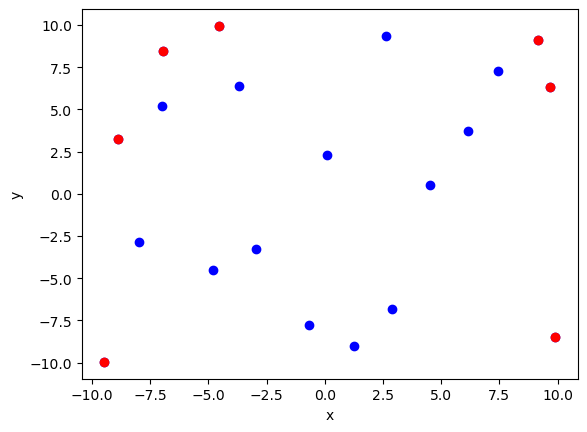

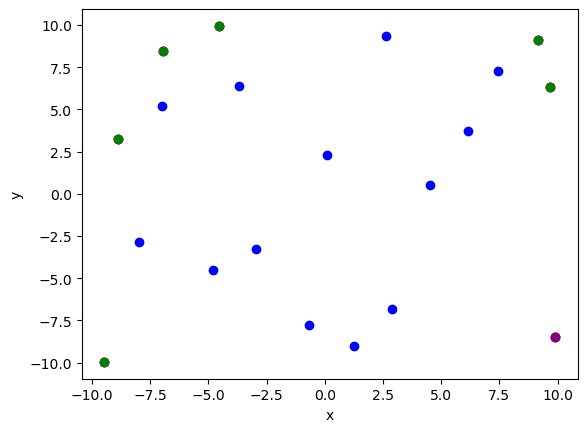

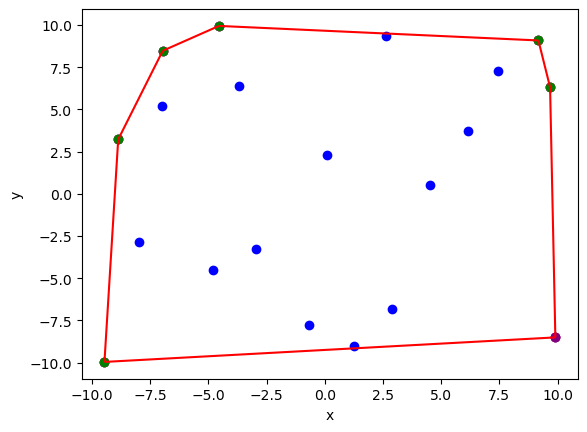

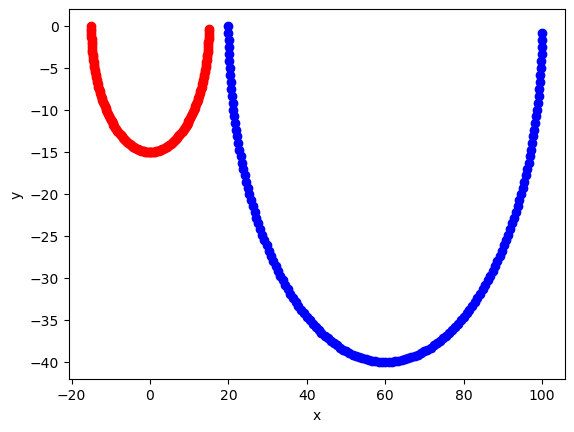

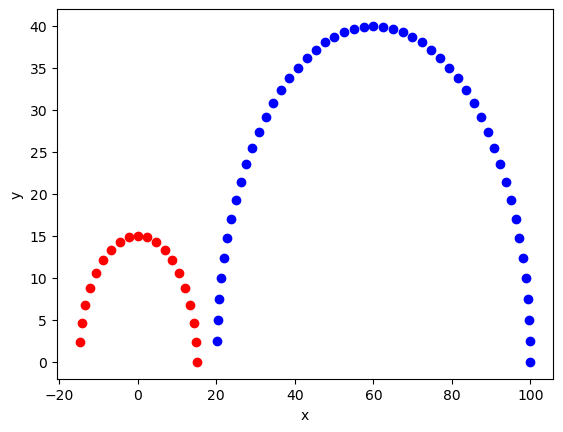

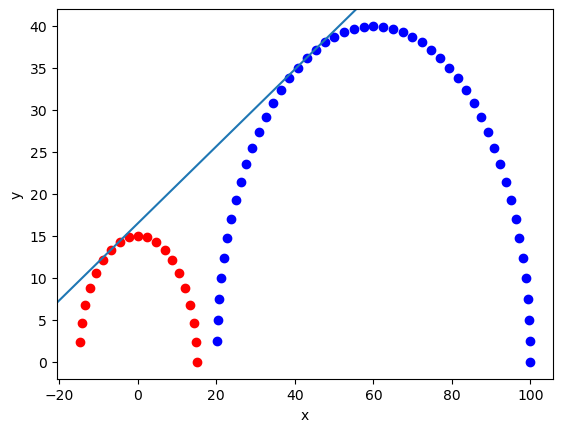

In [194]:
A_upper = upper_circle_points((0, 0), 15, 40, 2, 2)
B_upper = upper_circle_points((60, 0), 40, 100, 2, 2)
A_lower = lower_circle_points((0, 0), 15, 300, 2, 2)
B_lower = lower_circle_points((60, 0), 40, 300, 2, 2)
A_upper.reverse()
B_upper.reverse()


vis3 = Visualizer()
chuj = generate_uniform_points(-10, 10, 20)
chuj.sort()
chuj_new = convert(chuj)
print(chuj_new)
for i in range(20):
    vis3.add_point([chuj_new[i][0]], color = "blue")
brute_chuj = BruteHull(chuj_new)
vis3.add_point(brute_chuj, color = "red")
vis3.show()
up, down = classify(brute_chuj)
print(down)
vis3.add_point(up, color = "green")
vis3.add_point(down, color = "purple")
vis3.show()
down.reverse()
for i in range(len(down)):
    up.append(down[i])
add_perimeter(up, vis3, "red")
vis3.show()


vis2 = Visualizer()
vis2.add_point(A_lower, color = "red")
vis2.add_point(B_lower, color = "blue")
vis2.show()


vis1 = Visualizer()
vis1.add_point(A_upper, color = "red")
vis1.add_point(B_upper, color = "blue")
vis1.show()
x, y = bin_search(A_upper, B_upper)
vis1.add_line([(A_upper[x], B_upper[y])])
vis1.show()

